In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Downloading the dataset

In [ ]:
dataset = pd.read_csv('https://drive.google.com/uc?id=1AH4BiPGozkLhalMQdgqAfp0edCHi_pU1')
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

for i in X:
  if '<br /><br />' in i[0]:
    i[0].replace('<br /><br />',' ')

In [ ]:
from sklearn.model_selection import train_test_split
train_sent,test_sent,train_labels,test_labels = train_test_split(X,y,test_size=0.2)

In [ ]:
for i in range(len(train_labels)):
  if train_labels[i] == 'positive':
    train_labels[i] = 1
  else:
    train_labels[i] = 0
for i in range(len(test_labels)):
  if test_labels[i] == 'positive':
    test_labels[i] = 1
  else:
    test_labels[i] = 0

## Train-Test splitting, dividing into the features and labels

In [ ]:
train_labels_final = train_labels
test_labels_final = test_labels

In [ ]:
train_sentences = []
for i in train_sent:
  train_sentences.append(i[0])
test_sentences = []
for i in test_sent:
  test_sentences.append(i[0])

# Preparing the data set -> Tokenization

In [ ]:
vocab_size = 20000
word_embedding_dim = 200
char_embedding_dim = 200
max_length = 150
trunc_type = 'post'
oov_tok = '<OOV>'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [ ]:
# Creating the sentence matrices
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen = max_length,truncating = trunc_type,padding='post')
####################
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,maxlen = max_length,truncating = trunc_type,padding='post')

In [ ]:
# Creating the character based lists
char_trains = [] 
char_tests = []
for s in train_sentences:
  char_train = list(str(np.array(s)))
  char_trains.append(char_train)
for s in test_sentences:
  char_test = list(str(np.array(s)))
  char_tests.append(char_test)

In [ ]:
new_tokenizer = Tokenizer(num_words = 200,oov_token=oov_tok)
new_tokenizer.fit_on_texts(char_trains)
new_word_index = new_tokenizer.word_index

In [ ]:
# Creating the sentence matrices
new_sequences = new_tokenizer.texts_to_sequences(char_trains)
new_padded = pad_sequences(new_sequences,maxlen = max_length,truncating = trunc_type,padding='post')
####################
new_test_sequences = tokenizer.texts_to_sequences(char_tests)
new_test_padded = pad_sequences(new_test_sequences,maxlen = max_length,truncating = trunc_type,padding='post')

# Network Architecture
We have the following network architecture to classify the IMDB reviews

<img src='https://drive.google.com/uc?id=1_Kouy94AfmLmLUg2Cbw1CN0fbfcO5KzZ'>

In [ ]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.merge import concatenate

inp1 = Input(shape=(max_length,))
emb = Embedding(vocab_size+1, word_embedding_dim, input_length=max_length)(inp1)
f1 = Flatten()(emb)


inp2 = Input(shape=(max_length,))
emb2 = Embedding(vocab_size+1, char_embedding_dim, input_length=max_length)(inp2)
lstm = Bidirectional(LSTM(50))(emb2)
f2 = Flatten()(lstm)


merge = concatenate([f1, f2])
hidden1 = Dense(10, activation='relu')(merge)
output = Dense(1, activation='sigmoid')(hidden1)
model = Model(inputs=[inp1, inp2], outputs=output)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 200)     4000200     input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 200)     4000200     input_1[0][0]                    
______________________________________________________________________________________________

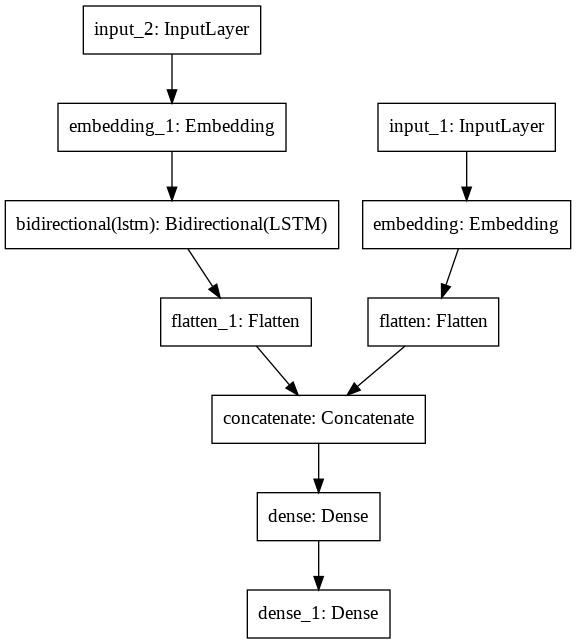

In [ ]:
print(model.summary())
# plot graph
plot_model(model, to_file='IMDB_REVIEW_RNN_graph.png')

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','AUC'])
history = model.fit([np.asarray(padded).astype(np.float32),np.asarray(new_padded).astype(np.float32)], np.asarray(train_labels_final).astype(np.float32).reshape(40000,1),batch_size=256, epochs=10, validation_data=([np.asarray(test_padded).astype(np.float32),np.asarray(new_test_padded).astype(np.float32)], np.asarray(test_labels_final).astype(np.float32)))

Epoch 1/30
157/157 [==============================] - 131s 805ms/step - loss: 0.5726 - accuracy: 0.6680 - auc: 0.7344 - val_loss: 0.3589 - val_accuracy: 0.8563 - val_auc: 0.9308
Epoch 2/30
157/157 [==============================] - 126s 801ms/step - loss: 0.2408 - accuracy: 0.9084 - auc: 0.9636 - val_loss: 0.3329 - val_accuracy: 0.8582 - val_auc: 0.9401
Epoch 3/30
157/157 [==============================] - 126s 804ms/step - loss: 0.1684 - accuracy: 0.9393 - auc: 0.9817 - val_loss: 0.3559 - val_accuracy: 0.8534 - val_auc: 0.9307
Epoch 4/30
157/157 [==============================] - 124s 793ms/step - loss: 0.1214 - accuracy: 0.9594 - auc: 0.9901 - val_loss: 0.4486 - val_accuracy: 0.8444 - val_auc: 0.9238
Epoch 5/30
157/157 [==============================] - 125s 797ms/step - loss: 0.0977 - accuracy: 0.9677 - auc: 0.9934 - val_loss: 0.5139 - val_accuracy: 0.8519 - val_auc: 0.9171
Epoch 6/30
157/157 [==============================] - 128s 813ms/step - loss: 0.0603 - accuracy: 0.9813 - auc:

<Figure size 432x288 with 0 Axes>

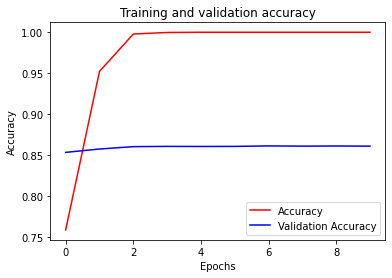

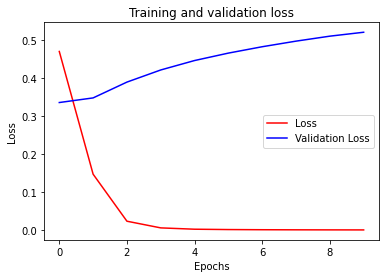

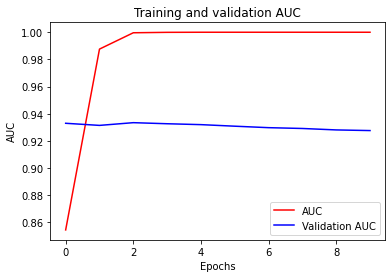

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

auc=history.history['auc']
val_auc=history.history['val_auc']
epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

#------------------------------------------------
# Plot training and validation auc per epoch
#------------------------------------------------
plt.plot(epochs, auc, 'r')
plt.plot(epochs, val_auc, 'b')
plt.title('Training and validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["AUC", "Validation AUC"])

plt.figure()

# Simple Test Phase

In [ ]:
sentence = "I really think this is amazing. honest."
word_sequence = tokenizer.texts_to_sequences([sentence])
print(word_sequence)

[[11, 63, 103, 12, 7, 484, 1160]]


In [ ]:
char_sequence = new_tokenizer.texts_to_sequences([list(sentence)])
print(char_sequence)

[[6, 2, 10, 3, 5, 12, 12, 19, 2, 4, 11, 6, 9, 26, 2, 4, 11, 6, 8, 2, 6, 8, 2, 5, 15, 5, 38, 6, 9, 18, 23, 2, 11, 7, 9, 3, 8, 4, 23]]


In [ ]:
pad1= pad_sequences(word_sequence,maxlen = max_length,truncating = trunc_type,padding='post')
pad2= pad_sequences(char_sequence,maxlen = max_length,truncating = trunc_type,padding='post')

In [ ]:
model.predict([pad1,pad2])
# The answer is 0.9971558, which means 1 (>0.5)
# From the sentence, we can easily say that it's apositive review

array([[0.9922799]], dtype=float32)

# Conclusion
If we look to the fitting and plotting part, we will see that we have an <b>OVERFITTING</b> <br>
Maybe we can avoit it by playing the number of epochs, learning rate, number of layers, Using GridSearchCV and etc.